# Accident Severity Notebook

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split


%matplotlib inline

pd.set_option('display.max_columns', None)

## Loading data

In [2]:
df = pd.read_csv('Collisions.csv')
df.head()

C:\Users\Chris\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.344896,47.717173,1,1003,1003,3503158,Matched,Block,NaN,AURORA AVE N BETWEEN N 117TH PL AND N 125TH ST,,NaN,2,Injury Collision,Cycles,2,0,1,1,1,0,0,2013/03/14 00:00:00+00,3/14/2013 5:30:00 PM,Driveway Junction,18.0,"MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END A...",NaN,N,Clear,Dry,Daylight,Y,NaN,NaN,45,Vehicle - Pedalcyclist,15057,0,N
1,-122.376467,47.543774,2,56200,56200,1795087,Matched,Block,NaN,35TH AVE SW BETWEEN SW MORGAN ST AND SW HOLLY ST,NaN,NaN,2,Injury Collision,Pedestrian,7,1,0,1,1,0,0,2006/01/15 00:00:00+00,1/15/2006 5:35:00 PM,Mid-Block (not related to intersection),24.0,MOTOR VEHCILE STRUCK PEDESTRIAN,NaN,0,Overcast,Dry,Dark - Street Lights On,NaN,6015003.0,NaN,0,Vehicle going straight hits pedestrian,0,0,N
2,-122.360735,47.701487,3,327037,328537,E979380,Matched,Intersection,37122.0,3RD AVE NW AND NW 100TH ST,,NaN,1,Property Damage Only Collision,Angles,2,0,0,2,0,0,0,2019/09/09 00:00:00+00,9/9/2019 3:32:00 PM,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
3,-122.297415,47.599233,4,327278,328778,E996362,Unmatched,Intersection,30602.0,M L KING JR WAY S AND S JACKSON ST,,NaN,1,Property Damage Only Collision,NaN,2,0,0,0,0,0,0,2019/12/19 00:00:00+00,12/19/2019,At Intersection (intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N
4,-122.368001,47.653585,5,1248,1248,3645424,Unmatched,Block,NaN,W EWING ST BETWEEN 6TH AVE W AND W EWING PL,,NaN,0,Unknown,NaN,1,0,0,0,0,0,0,2013/03/27 00:00:00+00,3/27/2013,Mid-Block (not related to intersection),0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,0,0,N


## Data cleaning
Here the columns to be used are selected and null values are dealt with

In [3]:
df.isna().sum()/len(df)

X                  0.033743
Y                  0.033743
OBJECTID           0.000000
INCKEY             0.000000
COLDETKEY          0.000000
REPORTNO           0.000000
STATUS             0.000000
ADDRTYPE           0.016757
INTKEY             0.675269
LOCATION           0.020720
EXCEPTRSNCODE      0.543519
EXCEPTRSNDESC      0.946828
SEVERITYCODE       0.000005
SEVERITYDESC       0.000000
COLLISIONTYPE      0.118781
PERSONCOUNT        0.000000
PEDCOUNT           0.000000
PEDCYLCOUNT        0.000000
VEHCOUNT           0.000000
INJURIES           0.000000
SERIOUSINJURIES    0.000000
FATALITIES         0.000000
INCDATE            0.000000
INCDTTM            0.000000
JUNCTIONTYPE       0.054053
SDOT_COLCODE       0.000005
SDOT_COLDESC       0.000005
INATTENTIONIND     0.863726
UNDERINFL          0.118691
WEATHER            0.119639
ROADCOND           0.119273
LIGHTCOND          0.120041
PEDROWNOTGRNT      0.976549
SDOTCOLNUM         0.425776
SPEEDING           0.955179
ST_COLCODE         0

In [4]:
# Remove time from date time string
df['INCDATE']=df['INCDATE'].str[:10]

# Add year month and day columns
df[['YEAR', 'MONTH','DAY']]=df["INCDATE"].str.split("/", expand=True)

# Transform String into DateTime
df['INCDATE'] = pd.to_datetime(df['INCDATE'])

# Get day of the week
# Monday=0, Sunday=6.
df['DAYOFWEEK'] = df['INCDATE'].dt.dayofweek

In [5]:
# Droping unnecessary columns or with a high number of na
dropcol_list = ['OBJECTID', 'X', 'Y', 'INCKEY', 'LOCATION', 'SEVERITYDESC',
                'COLDETKEY', 'REPORTNO', 'EXCEPTRSNCODE',
                'EXCEPTRSNDESC', 'STATUS', 'INTKEY', 'INCDATE',
                'INATTENTIONIND', 'PEDROWNOTGRNT', 'SPEEDING',
                'INCDTTM', 'SDOT_COLCODE', 'SDOT_COLDESC', 
                'SDOTCOLNUM', 'ST_COLCODE', 'ST_COLDESC', 
                'SEGLANEKEY', 'CROSSWALKKEY']
df.drop(dropcol_list, axis=1, inplace = True)

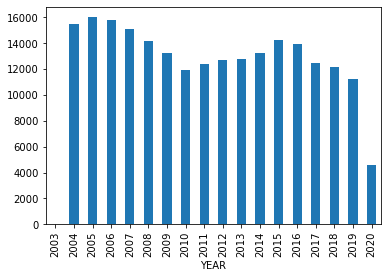

In [6]:
# Number of incidents each year
df.groupby('YEAR').size().plot.bar()

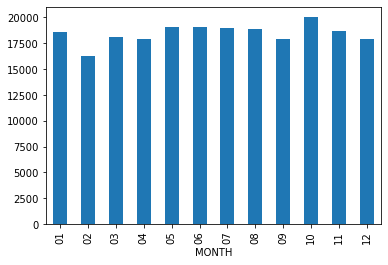

In [7]:
# Number of incidents by month
df.groupby('MONTH').size().plot.bar()

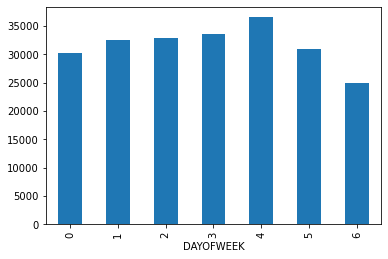

In [8]:
# Number of incidents by day of the week
# Monday=0, Sunday=6.
df.groupby('DAYOFWEEK').size().plot.bar()

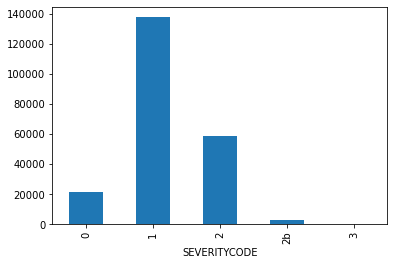

In [9]:
# Severity Code Distribution
df.groupby('SEVERITYCODE').size().plot.bar()

In [10]:
# Severity Code Distribution qty
df.groupby('SEVERITYCODE').size()

SEVERITYCODE
0      21615
1     137671
2      58783
2b      3105
3        350
dtype: int64

In [11]:
df.isna().sum()/len(df)

ADDRTYPE           0.016757
SEVERITYCODE       0.000005
COLLISIONTYPE      0.118781
PERSONCOUNT        0.000000
PEDCOUNT           0.000000
PEDCYLCOUNT        0.000000
VEHCOUNT           0.000000
INJURIES           0.000000
SERIOUSINJURIES    0.000000
FATALITIES         0.000000
JUNCTIONTYPE       0.054053
UNDERINFL          0.118691
WEATHER            0.119639
ROADCOND           0.119273
LIGHTCOND          0.120041
HITPARKEDCAR       0.000000
YEAR               0.000000
MONTH              0.000000
DAY                0.000000
DAYOFWEEK          0.000000
dtype: float64

In [12]:
print('-'*50)
print(df.groupby('ADDRTYPE').size() * 100 / len(df))
print('-'*50)
print(df.groupby('COLLISIONTYPE').size() * 100 / len(df))
print('-'*50)
print(df.groupby('JUNCTIONTYPE').size() * 100 / len(df))
print('-'*50)
print(df.groupby('UNDERINFL').size() * 100 / len(df))
print('-'*50)
print(df.groupby('HITPARKEDCAR').size() * 100 / len(df))

--------------------------------------------------
ADDRTYPE
Alley            0.396344
Block           65.454915
Intersection    32.473084
dtype: float64
--------------------------------------------------
COLLISIONTYPE
Angles        16.058233
Cycles         2.677802
Head On        0.987699
Left Turn      6.371741
Other         11.099424
Parked Car    21.916714
Pedestrian     3.460557
Rear Ended    15.660084
Right Turn     1.361923
Sideswipe      8.527706
dtype: float64
--------------------------------------------------
JUNCTIONTYPE
At Intersection (but not related to intersection)     1.127187
At Intersection (intersection related)               31.250649
Driveway Junction                                     5.189482
Mid-Block (but intersection related)                 11.019072
Mid-Block (not related to intersection)              45.913102
Ramp Junction                                         0.085769
Unknown                                               0.009480
dtype: float64
-------

### Data Cleaning

In [13]:
# Drop NAN rows
df.dropna(inplace=True)

Turn columns with categorical value

In [14]:
df.groupby('WEATHER').size() * 100 / len(df)

WEATHER
Blowing Sand/Dirt            0.026029
Clear                       59.821519
Fog/Smog/Smoke               0.299594
Other                        0.410613
Overcast                    14.878224
Partly Cloudy                0.005312
Raining                     17.807230
Severe Crosswind             0.013811
Sleet/Hail/Freezing Rain     0.061087
Snowing                      0.474357
Unknown                      6.202226
dtype: float64

In [15]:
# The 'unknown' values will count as 'clear'. Reason: 59.8% of weather is clear. Since clear is most frequent, it is most likely to occur
# Weather will be divided into good weather and bad weather
weather_cat = [
    'Blowing Sand/Dirt', 
    'Blowing Snow',
    'Clear',
    'Fog/Smog/Smoke',
    'Other',
    'Overcast',
    'Partly Cloudy',
    'Raining',
    'Severe Crosswind',
    'Sleet/Hail/Freezing Rain',
    'Snowing',
    'Unknown'    
]
weather_val = [
    0,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1
]
df['WEATHER'] = df['WEATHER'].replace(to_replace=weather_cat, value=weather_val)

In [16]:
df.groupby('WEATHER').size() * 100 / len(df)

WEATHER
0    33.976256
1    66.023744
dtype: float64

In [17]:
df.groupby('ROADCOND').size() * 100 / len(df)

ROADCOND
Dry               67.019734
Ice                0.637433
Oil                0.031872
Other              0.067462
Sand/Mud/Dirt      0.036652
Snow/Slush         0.524820
Standing Water     0.058963
Unknown            6.149637
Wet               25.473427
dtype: float64

In [18]:
# Same as with weather 'unknown' values will count as 'dry'. Reason: 67% of road condition is dry. Since dry is most frequent, it is most likely to occur
# Road condition will be divided into wether or not the road is in optimal condition
roadcond_cat = [
    'Dry',
    'Ice',
    'Oil',
    'Other',
    'Sand/Mud/Dirt',
    'Snow/Slush',
    'Standing Water',
    'Unknown',
    'Wet'
]
roadcond_val = [
1,
0,
0,
0,
0,
0,
0,
1,
0
]
df['ROADCOND'] = df['ROADCOND'].replace(to_replace=roadcond_cat, value=roadcond_val)

In [19]:
df.groupby('ROADCOND').size() * 100 / len(df)

ROADCOND
0    26.830629
1    73.169371
dtype: float64

In [20]:
df.groupby('LIGHTCOND').size() * 100 / len(df)

LIGHTCOND
Dark - No Street Lights      0.798385
Dark - Street Lights Off     0.635840
Dark - Street Lights On     26.107673
Dark - Unknown Lighting      0.012217
Dawn                         1.359326
Daylight                    62.231548
Dusk                         3.160075
Other                        0.115800
Unknown                      5.579135
dtype: float64

In [21]:
# In case of light condition 'unknown' values will count as 'daylight'. Reason: 62% of light condition is daylight. Since daylicht is most frequent, it is most likely to occur
# Every other category will have a value assigned
lightcond_cat = [
'Dark - No Street Lights',
'Dark - Street Lights Off',
'Dark - Street Lights On',
'Dark - Unknown Lighting',
'Dawn',
'Daylight',
'Dusk',
'Other',
'Unknown'
]
lightcond_val = [
0,
1,
2,
3,
4,
5,
6,
7,
5
]
df['LIGHTCOND'] = df['LIGHTCOND'].replace(to_replace=lightcond_cat, value=roadcond_val)

In [22]:
df.groupby('LIGHTCOND').size() * 100 / len(df)

LIGHTCOND
0    99.085814
1     0.914186
dtype: float64

In [23]:
# Checking for the rest of categorical values
print(df.dtypes)

ADDRTYPE           object
SEVERITYCODE       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INJURIES            int64
SERIOUSINJURIES     int64
FATALITIES          int64
JUNCTIONTYPE       object
UNDERINFL          object
WEATHER             int64
ROADCOND            int64
LIGHTCOND           int64
HITPARKEDCAR       object
YEAR               object
MONTH              object
DAY                object
DAYOFWEEK           int64
dtype: object


In [24]:
# SEVERITYCODE categorical values
severitycode_cat = ['0', '1', '2', '2b', '3']
severitycode_val = [0, 1, 2, 3, 4]

# ADDRTYPE categorical values
addrtype_cat = ['Alley', 'Block', 'Intersection']
addrtype_val = [0, 1, 2]

# COLLISIONTYPE categorical values
collisiontype_cat = [
    'Angles',
    'Cycles',
    'Head On',
    'Left Turn',
    'Other',
    'Parked Car',
    'Pedestrian',
    'Rear Ended',
    'Right Turn',
    'Sideswipe',
]
collisiontype_val = [
    0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9
]


# JUNCTIONTYPE categorical values
junctiontype_cat = [
    'At Intersection (but not related to intersection)',
    'At Intersection (intersection related)',
    'Driveway Junction',
    'Mid-Block (but intersection related)',
    'Mid-Block (not related to intersection)',
    'Ramp Junction',
    'Unknown'
]
junctiontype_val = [
    0,
    1,
    2,
    3,
    4,
    5,
    6
]

# UNDERINFL categorical values
underinfl_cat = [0,1,'N','Y']
underinfl_val = [0, 1, 0, 1]

# HITPARKEDCAR categorical values
hitparkedcar_cat = ['N', 'Y']
hitparkedcar_val = [ 0, 1]

# SEVERITYCODE
df['SEVERITYCODE'] = df['SEVERITYCODE'].replace(to_replace=severitycode_cat, value=severitycode_val)
# ADDRTYPE
df['ADDRTYPE'] = df['ADDRTYPE'].replace(to_replace=addrtype_cat, value=addrtype_val)
# COLLISIONTYPE
df['COLLISIONTYPE'] = df['COLLISIONTYPE'].replace(to_replace=collisiontype_cat, value=collisiontype_val)
# JUNCTIONTYPE
df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].replace(to_replace=junctiontype_cat, value=junctiontype_val)
# UNDERINFL
df['UNDERINFL'] = df['UNDERINFL'].replace(to_replace=underinfl_cat, value=underinfl_val).astype(int)
# HITPARKEDCAR
df['HITPARKEDCAR'] = df['HITPARKEDCAR'].replace(to_replace=hitparkedcar_cat, value=hitparkedcar_val)

In [25]:
print('-'*50)
print(df.groupby('SEVERITYCODE').size() * 100 / len(df))
print('-'*50)
print(df.groupby('ADDRTYPE').size() * 100 / len(df))
print('-'*50)
print(df.groupby('COLLISIONTYPE').size() * 100 / len(df))
print('-'*50)
print(df.groupby('JUNCTIONTYPE').size() * 100 / len(df))
print('-'*50)
print(df.groupby('UNDERINFL').size() * 100 / len(df))
print('-'*50)
print(df.groupby('HITPARKEDCAR').size() * 100 / len(df))

--------------------------------------------------
SEVERITYCODE
0     0.000531
1    67.759688
2    30.450718
3     1.609519
4     0.179544
dtype: float64
--------------------------------------------------
ADDRTYPE
0     0.126955
1    64.951794
2    34.921250
dtype: float64
--------------------------------------------------
COLLISIONTYPE
0    18.775597
1     3.119705
2     1.146317
3     7.460094
4    12.653582
5    23.191416
6     4.016361
7    18.187565
8     1.587740
9     9.861624
dtype: float64
--------------------------------------------------
JUNCTIONTYPE
0     1.107009
1    33.793525
2     5.695466
3    12.032084
4    47.281613
5     0.087647
6     0.002656
dtype: float64
--------------------------------------------------
UNDERINFL
0    94.956309
1     5.043691
dtype: float64
--------------------------------------------------
HITPARKEDCAR
0    96.823989
1     3.176011
dtype: float64


## Feature selection
Feature X definition:

In [41]:
#    'ADDRTYPE','SEVERITYCODE',
#    'COLLISIONTYPE','PERSONCOUNT',
#    'PEDCOUNT','PEDCYLCOUNT','VEHCOUNT',
#    'INJURIES', 'SERIOUSINJURIES',
#    'FATALITIES', 'JUNCTIONTYPE',
#    'UNDERINFL', 'WEATHER',
#    'ROADCOND', 'LIGHTCOND',
#    'HITPARKEDCAR', 'DAYOFWEEK'

cols = [
    'ADDRTYPE',
    'COLLISIONTYPE','JUNCTIONTYPE',
    'UNDERINFL', 'WEATHER',
    'ROADCOND', 'LIGHTCOND',
    'DAYOFWEEK'
]
X = df[cols]
X[0:5]

,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,DAYOFWEEK
0,1,1,2,0,1,1,0,3
1,1,6,4,0,0,1,0,6
2,2,0,1,0,0,0,0,0
5,2,3,1,0,1,1,0,3
6,2,9,1,0,1,1,0,4


In [42]:
y = df['SEVERITYCODE'].values
y[0:5]

array([2, 2, 1, 2, 1], dtype=int64)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)
print(X_train[0:5])
print(y_train[0:5])

X_train shape:  (150604, 8)
X_test shape:  (37651, 8)
y_train shape:  (150604,)
y_test shape:  (37651,)
        ADDRTYPE  COLLISIONTYPE  JUNCTIONTYPE  UNDERINFL  WEATHER  ROADCOND  \
102119         2              0             1          0        0         0   
96463          2              9             1          0        1         1   
12176          1              7             3          0        1         1   
68377          1              7             3          0        1         1   
144902         1              5             4          0        1         1   

        LIGHTCOND  DAYOFWEEK  
102119          0          3  
96463           0          5  
12176           0          1  
68377           0          5  
144902          0          1  
[2 1 2 2 1]


### Data Standardization

In [44]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[-0.72643125, -1.23296776, -0.51408466, -0.23046889,  0.71736087,
         0.60555105, -0.09605311,  0.02735883],
       [-0.72643125,  0.54245745,  0.93687497, -0.23046889, -1.39399854,
         0.60555105, -0.09605311,  1.58825458],
       [ 1.36135714, -1.5880528 , -1.23956448, -0.23046889, -1.39399854,
        -1.65138843, -0.09605311, -1.53353693],
       [ 1.36135714, -0.52279767, -1.23956448, -0.23046889,  0.71736087,
         0.60555105, -0.09605311,  0.02735883],
       [ 1.36135714,  1.60771258, -1.23956448, -0.23046889,  0.71736087,
         0.60555105, -0.09605311,  0.54765741]])

### Building models and comparing them
#### KNN

In [45]:
k = 3
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(n_neighbors=3)

In [46]:
yhat = kNN_model.predict(X_test)
yhat[0:5]

array([2, 2, 2, 2, 1], dtype=int64)

In [47]:
# Best k
Ks=7
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range(1,Ks):
    
    #Train Model and Predict  
    kNN_model = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = kNN_model.predict(X_test)
    
    
    mean_acc[n-1]=np.mean(yhat==y_test);
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.64271865, 0.68872009, 0.68144272, 0.69554594, 0.69291652,
       0.69796287])

In [48]:
# Building the model again, using k=4
from sklearn.neighbors import KNeighborsClassifier
k = 4
#Train Model and Predict  
kNN_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
kNN_model

KNeighborsClassifier(n_neighbors=4)

#### Decision tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
DT_model = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
DT_model.fit(X_train,y_train)
DT_model

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [50]:
yhat = DT_model.predict(X_test)
yhat

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

#### Support Vector Machine

In [ ]:
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train) 

In [ ]:
yhat = SVM_model.predict(X_test)
yhat

#### Logistic Regression

In [ ]:
LR_model = LogisticRegression(C=0.01).fit(X_train,y_train)
LR_model

In [ ]:
yhat = LR_model.predict(X_test)
yhat

##### Evaluation

In [ ]:
knn_yhat = kNN_model.predict(test_X)
print("KNN Jaccard index: %.2f" % jaccard_similarity_score(test_y, knn_yhat))
print("KNN F1-score: %.2f" % f1_score(test_y, knn_yhat, average='weighted') )

In [ ]:
DT_yhat = DT_model.predict(test_X)
print("DT Jaccard index: %.2f" % jaccard_similarity_score(test_y, DT_yhat))
print("DT F1-score: %.2f" % f1_score(test_y, DT_yhat, average='weighted') )

In [ ]:
SVM_yhat = SVM_model.predict(test_X)
print("SVM Jaccard index: %.2f" % jaccard_similarity_score(test_y, SVM_yhat))
print("SVM F1-score: %.2f" % f1_score(test_y, SVM_yhat, average='weighted') )

In [ ]:
LR_yhat = LR_model.predict(test_X)
LR_yhat_prob = LR_model.predict_proba(test_X)
print("LR Jaccard index: %.2f" % jaccard_similarity_score(test_y, LR_yhat))
print("LR F1-score: %.2f" % f1_score(test_y, LR_yhat, average='weighted') )
print("LR LogLoss: %.2f" % log_loss(test_y, LR_yhat_prob))

## Report
The accuracy of the different methods are compared in the next table

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.67    | 0.63     | NA      |
| Decision Tree      | 0.72    | 0.74     | NA      |
| SVM                | 0.80    | 0.76     | NA      |
| LogisticRegression | 0.74    | 0.66     | 0.57    |